# Chapter 9: CycleGAN
This Colab / Ipython notebook will walk you through: 
1. Install extra dependencies that Colab does not natively support
2. Download the apple2orange dataset using the `%%bash` magic.
3. Create the `DataLoader()` class that server as our core data structure
4. Do all the necessary imports
5. Define the CycleGAN in the following steps:

> 5.1 Define the key hyper-parameters and flow

> 5.2 Define the static methods we are going to be reusing in the generator and discriminator

> 5.3 Build the generator and the discriminator

> 5.4 Define the helper function for sampling our translated images

> 5.5 Define the explicit training loop

6. Fit the CycleGAN and talk about the results!


--- 

## Helper functions 
1. Pip installing directly from GitHub the `keras-contrib` folder, which we will need for the `InstanceNormalization`. We tested this git-hash version of the repository: 
`46fcdb9384b3bc9399c651b2b43640aa54098e64`
2. Downloading the dataset to our cloud-based—ephemeral—storage

In [1]:
#@title
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-54i40786
  Running setup.py bdist_wheel for keras-contrib ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-0ddpk6dn/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
%%bash

FILE=apple2orange
mkdir ./datasets

URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
ZIP_FILE=./datasets/$FILE.zip
TARGET_DIR=./datasets/$FILE/
wget -N $URL -O $ZIP_FILE
mkdir $TARGET_DIR
unzip $ZIP_FILE -d ./datasets/
rm $ZIP_FILE

Archive:  ./datasets/apple2orange.zip
  inflating: ./datasets/ILE          


mkdir: cannot create directory ‘./datasets’: File exists
for details.

--2023-02-23 16:37:14--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... ::ffff:128.32.244.190, 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|::ffff:128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘./datasets/apple2orange.zip’

     0K .......... .......... .......... .......... ..........  0% 53.5K 23m50s
    50K .......... .......... .......... .......... ..........  0%  136K 16m37s
   100K .......... .......... .......... .......... ..........  0% 84.8K 16m5s
   150K .......... .......... .......... .......... ..........  0%  209K 13m34s
   200K .......... .......... .......... .......... ..........  0%  192K 12m11s
   250K .......... .......... .......... .......... ..........  0%  107K 12m7s
   3

CalledProcessError: Command 'b'\nFILE=apple2orange\nmkdir ./datasets\n\nURL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip\nZIP_FILE=./datasets/$FILE.zip\nTARGET_DIR=./datasets/$FILE/\nwget -N $URL -O $ZIP_FILE\nmkdir $TARGET_DIR\nunzip $ZIP_FILE -d ./datasets/\nrm $ZIP_FILE\n'' returned non-zero exit status 1

## DataLoader
We define our key data-holding object in the (hidden) cell below. With it, we can:
1. `load_data` from disk based on the dataset name, which we will define in `CycleGAN`'s `__init__`
2. `load_batch` during training—note this defined as a generator for greater efficiency
3. A helper functions called `imread`, which we use in `load_data`

In [21]:
#@title
import scipy
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = scipy.misc.imresize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = scipy.misc.imresize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = scipy.misc.imresize(img_A, self.img_res)
                img_B = scipy.misc.imresize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return scipy.misc.imread(path, mode='RGB').astype(np.float)


## Good old imports

In [33]:
from __future__ import print_function, division
import scipy
from keras.datasets import mnist
# from keras_contrib.layers.normalization import InstanceNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

## CycleGAN itself

1. We define some parameters
2. We build the discriminators and compile them
3. We build the generators and compile them (these are a bit more complicated)

In [24]:
class CycleGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        # Configure data loader
        self.dataset_name = 'apple2orange'
        # Use the DataLoader object to import a preprocessed dataset
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_rows, self.img_cols))

        # Calculate output shape of D (PatchGAN)
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)

        # Number of filters in the first layer of G and D
        self.gf = 32
        self.df = 64

        # Loss weights
        self.lambda_cycle = 10.0                    # Cycle-consistency loss
        self.lambda_id = 0.9 * self.lambda_cycle    # Identity loss

        optimizer = Adam(0.0002, 0.5)
        
        # Build and compile the discriminators
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])

        #-------------------------
        # Construct Computational
        #   Graph of Generators
        #-------------------------

        # Build the generators
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images to the other domain
        fake_B = self.g_AB(img_A)
        fake_A = self.g_BA(img_B)
        # Translate images back to original domain
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        # Identity mapping of images
        img_A_id = self.g_BA(img_A)
        img_B_id = self.g_AB(img_B)

        # For the combined model we will only train the generators
        self.d_A.trainable = False
        self.d_B.trainable = False

        # Discriminators determines validity of translated images
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)

        # Combined model trains generators to fool discriminators
        self.combined = Model(inputs=[img_A, img_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       img_A_id, img_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                              loss_weights=[1, 1,
                                            self.lambda_cycle, self.lambda_cycle,
                                            self.lambda_id, self.lambda_id],
                              optimizer=optimizer)

## Static methods
Two things to pay attention to:
1. We are using a `CycleGAN` class that inherits from the `CycleGAN` class from the previous cell. As far as I know, this is the best way of defining a class across multiple cells for educational purposes. But I agree with Joel Grus—this is not the best way, but I still like notebooks.
2. We are using `@staticmethod`, which allows us to shrink the code size by further ~25 lines. For more on [static methods I found this SO answer to be quite good](https://stackoverflow.com/questions/136097/what-is-the-difference-between-staticmethod-and-classmethod). We will use these later to more compactly write both the generator and the discriminator. 

In [25]:
class CycleGAN(CycleGAN):
      @staticmethod
      def conv2d(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size,
                   strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
      
      @staticmethod
      def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1,
                       padding='same', activation='relu')(u)
            if dropout_rate:
                u = Dropout(dropout_rate)(u)
            u = InstanceNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u


## Generator

In [26]:
class CycleGAN(CycleGAN):
    def build_generator(self):
        """U-Net Generator"""
        # Image input
        d0 = Input(shape=self.img_shape)

        # Downsampling
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)

        # Upsampling
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)

        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same', activation='tanh')(u4)

        return Model(d0, output_img)

## Discriminator

In [27]:
class CycleGAN(CycleGAN):
    def build_discriminator(self):
      img = Input(shape=self.img_shape)

      d1 = self.conv2d(img, self.df, normalization=False)
      d2 = self.conv2d(d1, self.df * 2)
      d3 = self.conv2d(d2, self.df * 4)
      d4 = self.conv2d(d3, self.df * 8)

      validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

      return Model(img, validity)

## Sampling function
This is how we got the output in the Chapter. We need to run in special mode to get the translated images out, because now we are in "testing"/evaluation mode.

We then plot the whole cycle:

$ A -> \hat B -> \hat A$

As well as:

$ B -> \hat A -> \hat B$

In [28]:
class CycleGAN(CycleGAN):
      def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.data_loader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

## Training loop

Here is where the real magic happens.



In [29]:
class CycleGAN(CycleGAN):
      def train(self, epochs, batch_size=1, sample_interval=50):
        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)


        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):

                # ----------------------
                #  Train Discriminators
                # ----------------------

                # Translate images to opposite domain
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)

                # Train the discriminators (original images = real / translated = Fake)
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

                # Total discriminator loss
                d_loss = 0.5 * np.add(dA_loss, dB_loss)

                # ------------------
                #  Train Generators
                # ------------------

                # Train the generators
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                # If at save interval => plot the generated image samples
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

## Train the CycleGAN

Because we used the object-oriented design, we now need to instantiate the CycleGAN and run the `train`ing method.

In [35]:
!mkdir images
!mkdir images/apple2orange

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:55: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


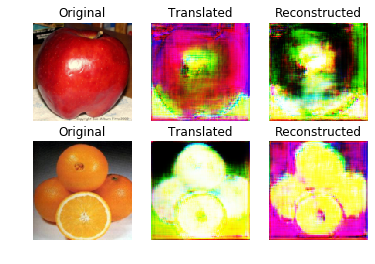

In [ ]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=100, batch_size=64, sample_interval=10)

## Now we can look at the results!

You may have three observations:
1. The progress can be slow—even on the Colab GPU or on CPU.
2. The initial images can be quite bad and make no sense at all, but worry not—soon enough, the images will manage at least a decent reconstruction.
3. The later reconstructions are generally mixed: some look very convincing—such as the ones below—but some are merely an orange "repainting" of the apples and vice versa. Even the original authors of the paper mention this problem: CycleGAN is unable to substantially change the structure of the image, but only "restylize" it. So beware of this limitation.

![Good examples](https://i.ibb.co/n00BW1F/163-10.png)

Also, this is a good introduction to the reality of being a GAN researcher / practitioner. Most flashy results still tend to be cherry picked and most papers—e.g. [BigGAN being a notable exception](https://arxiv.org/abs/1809.11096)—do not share failure cases. BigGAN—the state of the art as of today (20/11/2018)—even [publishes Google folders worth of examples](https://drive.google.com/drive/folders/1SRYj8Ou1JZ4e09LqeawDHcUvoeY78tPO). 